## Importing libraries and setting up environment
#### Loading ML, NLP, and utility packages while configuring randomness, warnings, and device information


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

import warnings
warnings.filterwarnings("ignore")

from transformers import logging
logging.set_verbosity_error()


from datasets import Dataset as HFDataset
import os
from time import time
import json

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f" Imports complete")
print(f" PyTorch version: {torch.__version__}")
print(f" Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    try:
        print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    except Exception:
        pass

 Imports complete
 PyTorch version: 2.8.0+cu126
 Device: GPU
   GPU Name: Tesla T4


## Loading and splitting the dataset
#### Reading Excel files and creating train/validation splits


In [6]:
from sklearn.model_selection import train_test_split

TRAIN_PATH = "/content/Training.xlsx"
TEST_PATH = "/content/Validation.xlsx"

# Load datasets
full_train_df = pd.read_excel(TRAIN_PATH)
test_df = pd.read_excel(TEST_PATH)

# Split training into train + validation
train_df, val_df = train_test_split(
    full_train_df,
    test_size=0.15,
    random_state=42,
    stratify=full_train_df['categories']
)

print(f"Total training file: {len(full_train_df)}")
print(f"Training split: {len(train_df)}")
print(f"Validation split: {len(val_df)}")
print(f"Test dataset: {len(test_df)}")


Total training file: 8936
Training split: 7595
Validation split: 1341
Test dataset: 2681


## Tokenizer setup and address length analysis
#### Loading tokenizer and computing token-length statistics to decide max sequence length


In [8]:
MODEL_NAME = "ai4bharat/IndicBERTv2-MLM-only"
print(f"\n Loading tokenizer: {MODEL_NAME}")

from transformers import logging
logging.set_verbosity_error()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(" Tokenizer loaded successfully")
try:
    vocab_size = tokenizer.vocab_size
except Exception:
    vocab_size = getattr(tokenizer, "size", "unknown")
print(f"   Vocab size: {vocab_size}")

# Analyze token length distribution
print("\n Analyzing address lengths...")

def get_token_length(text):
    """Get number of tokens for a text using tokenizer (fast path)."""
    return len(tokenizer.encode(str(text), add_special_tokens=True))

train_lengths = train_df['property_address'].apply(get_token_length)
val_lengths = val_df['property_address'].apply(get_token_length)

# Statistics
print(f"\n{'='*60}")
print("TOKEN LENGTH STATISTICS")
print(f"{'='*60}")
print(f"{'Metric':<20s} {'Training':>15s} {'Validation':>15s}")
print("-" * 60)
print(f"{'Mean':<20s} {train_lengths.mean():>15.2f} {val_lengths.mean():>15.2f}")
print(f"{'Median':<20s} {train_lengths.median():>15.0f} {val_lengths.median():>15.0f}")
print(f"{'95th percentile':<20s} {train_lengths.quantile(0.95):>15.0f} {val_lengths.quantile(0.95):>15.0f}")
print(f"{'Max':<20s} {train_lengths.max():>15.0f} {val_lengths.max():>15.0f}")

# Determine optimal max_length
suggested_max_length = int(train_lengths.quantile(0.95))
MAX_LENGTH = ((suggested_max_length + 15) // 16) * 16  # Round to nearest 16

print(f"\n Selected MAX_LENGTH: {MAX_LENGTH}")
print(f"   Covers {(train_lengths <= MAX_LENGTH).mean()*100:.2f}% of training samples")


 Loading tokenizer: ai4bharat/IndicBERTv2-MLM-only
 Tokenizer loaded successfully
   Vocab size: 250000

 Analyzing address lengths...

TOKEN LENGTH STATISTICS
Metric                      Training      Validation
------------------------------------------------------------
Mean                           47.36           45.51
Median                            41              40
95th percentile                   99              93
Max                              336             218

 Selected MAX_LENGTH: 112
   Covers 96.95% of training samples


## Label encoding and dataset preparation
#### Creating label mappings, computing class weights, tokenizing text, and converting data into HF datasets


In [11]:
# Create label mappings
categories = sorted(train_df['categories'].unique())
label2id = {label: idx for idx, label in enumerate(categories)}
id2label = {idx: label for label, idx in label2id.items()}

from datasets import disable_progress_bar
disable_progress_bar()

print("\n Label Mappings:")
for label, idx in label2id.items():
    print(f"   {idx}: {label}")

# Add numerical labels
train_df['label'] = train_df['categories'].map(label2id)
val_df['label'] = val_df['categories'].map(label2id)

# Calculate class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

# Manual adjustment for weakest performers
class_weights = torch.FloatTensor(class_weights_array)
manual_weights = {}
for label, idx in label2id.items():
    if label == 'landparcel':
        manual_weights[idx] = class_weights[idx] * 1.5  # Extra boost
    elif label == 'others':
        manual_weights[idx] = class_weights[idx] * 1.3  # Extra boost
    else:
        manual_weights[idx] = class_weights[idx]

class_weights = torch.FloatTensor([manual_weights[i] for i in range(len(categories))])

print("\n  Class Weights (Higher = More Focus):")
for idx, label in id2label.items():
    print(f"   {label:20s}: {class_weights[idx]:.3f}")

# Tokenization function (return python lists; do not set return_tensors='pt')
def tokenize_function(examples):
    """Tokenize addresses with padding and truncation. Returns lists (compatible with datasets.map)."""
    return tokenizer(
        examples['property_address'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
    )

# Convert to HuggingFace datasets (remove pandas index column)
train_dataset = HFDataset.from_pandas(train_df[['property_address', 'label']].reset_index(drop=True))
val_dataset = HFDataset.from_pandas(val_df[['property_address', 'label']].reset_index(drop=True))

# Tokenize (batched). This returns lists for input_ids/attention_mask.
print("\n Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['property_address'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['property_address'])

# Trainer expects the label column to be named "labels"
if 'label' in train_dataset.column_names:
    train_dataset = train_dataset.rename_column('label', 'labels')
if 'label' in val_dataset.column_names:
    val_dataset = val_dataset.rename_column('label', 'labels')

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

print(f" Datasets prepared")
print(f"   Training: {len(train_dataset):,} samples")
print(f"   Validation: {len(val_dataset):,} samples")


 Label Mappings:
   0: commercial unit
   1: flat
   2: houseorplot
   3: landparcel
   4: others

  Class Weights (Higher = More Focus):
   commercial unit     : 1.852
   flat                : 0.553
   houseorplot         : 0.669
   landparcel          : 3.083
   others              : 1.942

 Tokenizing datasets...
 Datasets prepared
   Training: 7,595 samples
   Validation: 1,341 samples


## Model initialization and training setup
#### Loading the model, defining weighted loss, configuring training arguments, and initializing the Trainer


In [13]:
print(f"\n Loading model: {MODEL_NAME}")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
)

print(" Model loaded successfully")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

import transformers
transformers.utils.logging.set_verbosity_error()

from datasets import disable_progress_bar
disable_progress_bar()


# Disable tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Custom Trainer with weighted loss
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Compute weighted loss robustly:
         - labels are expected in inputs['labels']
         - handle DataParallel / device issues by using parameter device
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Get device from model parameters (works with DataParallel, single GPU, CPU)
        try:
            device = next(model.parameters()).device
        except StopIteration:
            # Fallback: CPU
            device = torch.device('cpu')

        # Move class weights to the correct device
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(device))
        loss = loss_fct(logits, labels.to(device))

        return (loss, outputs) if return_outputs else loss

# Metrics computation
def compute_metrics(eval_pred):
    """Compute comprehensive evaluation metrics"""
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    weighted_f1 = f1_score(labels, preds, average='weighted')
    macro_precision = precision_score(labels, preds, average='macro', zero_division=0)
    macro_recall = recall_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall
    }

# Training arguments
OUTPUT_DIR = "./indicbert_property_classifier"
EPOCHS = 6
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

# Check transformers version for compatibility
import transformers
transformers_version = tuple(int(x) for x in transformers.__version__.split('.')[:2])

# Use eval_strategy for newer versions (4.40+), evaluation_strategy for older
if transformers_version >= (4, 40):
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        learning_rate=LEARNING_RATE,
        weight_decay=0.01,
        warmup_ratio=0.1,

        # Evaluation strategy (NEW parameter names for transformers 4.40+)
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,

        # Logging
        logging_dir=f"{OUTPUT_DIR}/logs",
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",

        # Optimization
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=2,

        # Reproducibility
        seed=RANDOM_SEED,

        # Save settings
        save_total_limit=2,
    )
else:
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        learning_rate=LEARNING_RATE,
        weight_decay=0.01,
        warmup_ratio=0.1,

        # Evaluation strategy (OLD parameter names for transformers < 4.40)
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,

        # Logging
        logging_dir=f"{OUTPUT_DIR}/logs",
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",

        # Optimization
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=2,

        # Reproducibility
        seed=RANDOM_SEED,

        # Save settings
        save_total_limit=2,
    )

print("\n  Training Configuration:")
print(f"{'='*60}")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Max length: {MAX_LENGTH}")
print(f"   Weight decay: {training_args.weight_decay}")
print(f"   FP16: {training_args.fp16}")
print(f"{'='*60}")

# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("\n Trainer initialized")



 Loading model: ai4bharat/IndicBERTv2-MLM-only
 Model loaded successfully
   Total parameters: 278,045,189

  Training Configuration:
   Epochs: 6
   Batch size: 16
   Learning rate: 2e-05
   Max length: 112
   Weight decay: 0.01
   FP16: True

 Trainer initialized


## Model training and log extraction
#### Starting training, timing the run.

In [14]:
print("\n" + "="*80)
print(" STARTING TRAINING")
print("="*80)

start_time = time()
train_result = trainer.train()
train_time = time() - start_time

print(f"\n Training completed in {train_time/60:.2f} minutes")

# Extract and display training history in a DataFrame
import pandas as pd

# Filter for evaluation logs (which typically contain all metrics at epoch end)
# and also include the final training loss
training_logs = []
for log_entry in trainer.state.log_history:
    if 'eval_loss' in log_entry or 'loss' in log_entry: # Include both eval and train loss entries
        training_logs.append(log_entry)

# Convert to DataFrame for better visualization
training_df = pd.DataFrame(training_logs)

# Clean up column names and order for readability
# Remove redundant step/grad_norm from epoch-end eval logs if they are not meaningful
training_df = training_df.drop(columns=['grad_norm', 'learning_rate', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second'], errors='ignore')

print("\nTraining History:")
display(training_df.fillna('-').round(4))


 STARTING TRAINING
{'loss': 1.6142, 'grad_norm': nan, 'learning_rate': 3.4385964912280705e-06, 'epoch': 0.10526315789473684}
{'loss': 1.5892, 'grad_norm': 3.613410472869873, 'learning_rate': 6.947368421052632e-06, 'epoch': 0.21052631578947367}
{'loss': 1.3947, 'grad_norm': 10.341691970825195, 'learning_rate': 1.0456140350877194e-05, 'epoch': 0.3157894736842105}
{'loss': 1.1429, 'grad_norm': 5.3756232261657715, 'learning_rate': 1.3964912280701755e-05, 'epoch': 0.42105263157894735}
{'loss': 0.796, 'grad_norm': 9.606307983398438, 'learning_rate': 1.7473684210526317e-05, 'epoch': 0.5263157894736842}
{'loss': 0.6757, 'grad_norm': 4.917308807373047, 'learning_rate': 1.9890838206627684e-05, 'epoch': 0.631578947368421}
{'loss': 0.4875, 'grad_norm': 3.0388259887695312, 'learning_rate': 1.9500974658869397e-05, 'epoch': 0.7368421052631579}
{'loss': 0.4286, 'grad_norm': 7.9024271965026855, 'learning_rate': 1.9111111111111113e-05, 'epoch': 0.8421052631578947}
{'loss': 0.4488, 'grad_norm': 1.747912

,loss,epoch,step,eval_loss,eval_accuracy,eval_macro_f1,eval_weighted_f1,eval_macro_precision,eval_macro_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,1.6142,0.1053,50,-,-,-,-,-,-,-,-,-
1,1.5892,0.2105,100,-,-,-,-,-,-,-,-,-
2,1.3947,0.3158,150,-,-,-,-,-,-,-,-,-
3,1.1429,0.4211,200,-,-,-,-,-,-,-,-,-
4,0.796,0.5263,250,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.0389,5.6842,2700,-,-,-,-,-,-,-,-,-
59,0.108,5.7895,2750,-,-,-,-,-,-,-,-,-
60,0.0642,5.8947,2800,-,-,-,-,-,-,-,-,-
61,0.057,6.0000,2850,-,-,-,-,-,-,-,-,-


## Test set evaluation
#### Tokenizing the test data, generating predictions, and printing the classification report


In [15]:
# Prepare test set dataset
test_df['label'] = test_df['categories'].map(label2id)

test_dataset = HFDataset.from_pandas(
    test_df[['property_address', 'label']]
)

test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.rename_column('label', 'labels')

test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Run prediction on test dataset
test_predictions = trainer.predict(test_dataset)
y_pred_test = np.argmax(test_predictions.predictions, axis=1)
y_true_test = test_df['label'].values

print("Test Set Results:")
print(classification_report(
    y_true_test,
    y_pred_test,
    target_names=categories
))


Test Set Results:
                 precision    recall  f1-score   support

commercial unit       0.98      0.98      0.98       290
           flat       0.96      0.95      0.96       970
    houseorplot       0.91      0.92      0.92       802
     landparcel       0.86      0.85      0.85       260
         others       0.88      0.90      0.89       359

       accuracy                           0.93      2681
      macro avg       0.92      0.92      0.92      2681
   weighted avg       0.93      0.93      0.93      2681



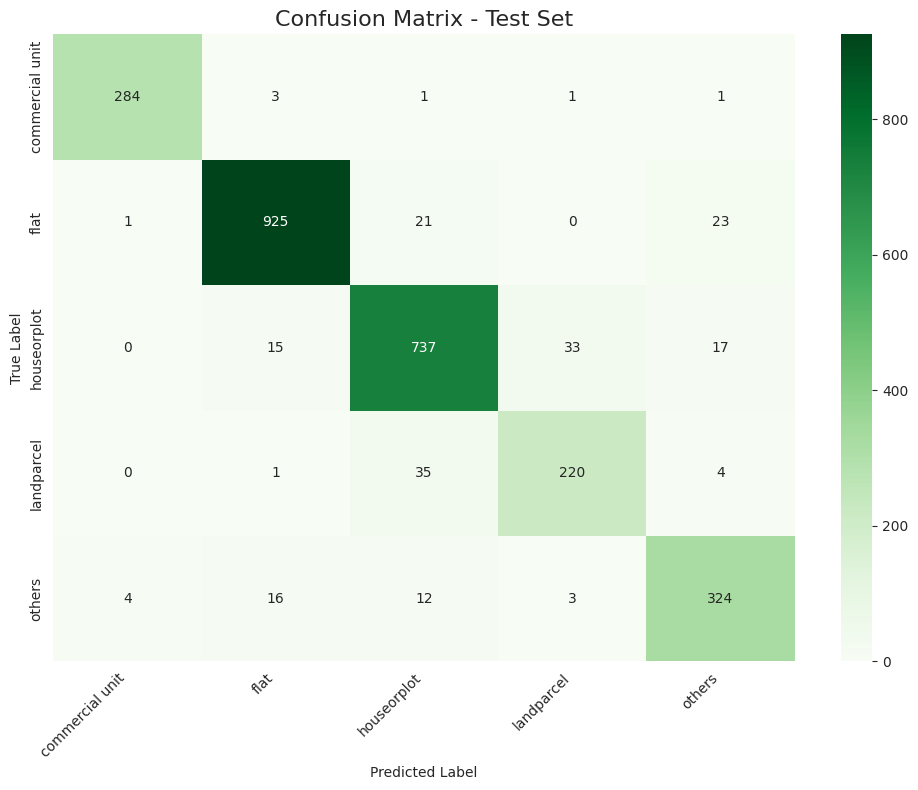

In [16]:
test_predictions = trainer.predict(test_dataset)
y_pred_test = np.argmax(test_predictions.predictions, axis=1)
y_true_test = test_df['label'].values

cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    xticklabels=categories,
    yticklabels=categories,
    cmap="Greens"
)

plt.title("Confusion Matrix - Test Set", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


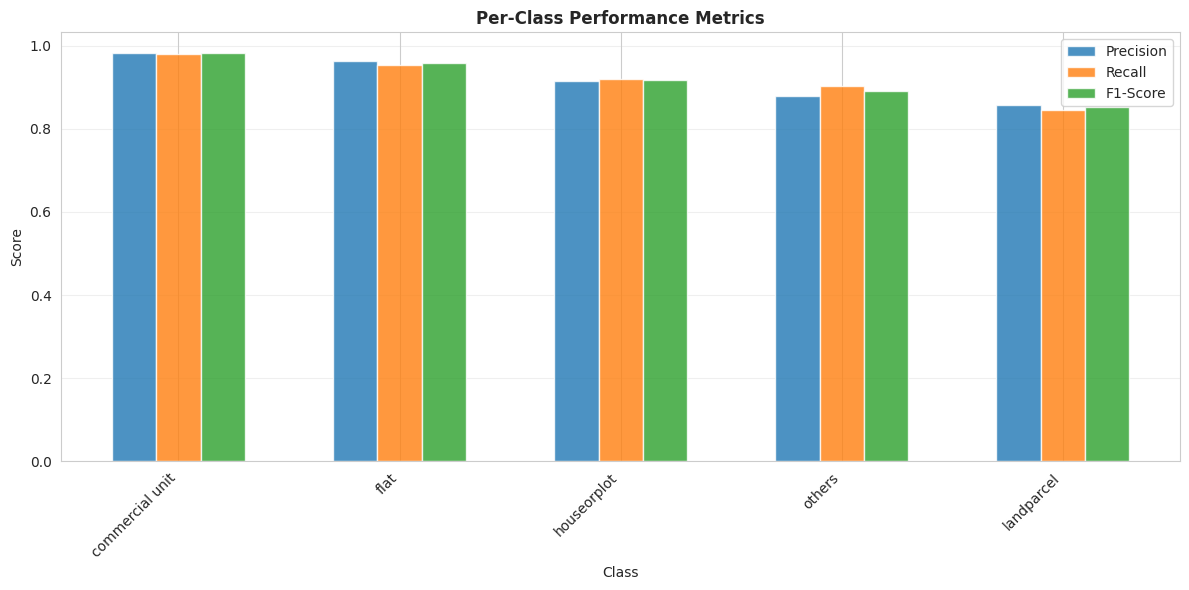


Best Performing Classes:


,precision,recall,f1-score,support
commercial unit,0.982699,0.979310,0.981002,290.0
flat,0.963542,0.953608,0.958549,970.0
houseorplot,0.914392,0.918953,0.916667,802.0



Worst Performing Classes:


,precision,recall,f1-score,support
houseorplot,0.914392,0.918953,0.916667,802.0
others,0.878049,0.902507,0.890110,359.0
landparcel,0.856031,0.846154,0.851064,260.0


In [17]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate classification report as dictionary
report_dict = classification_report(
    y_true_test,
    y_pred_test,
    target_names=categories,
    output_dict=True
)

# Convert to dataframe and remove avg rows
class_metrics = pd.DataFrame(report_dict).T.iloc[:-3]
class_metrics = class_metrics.sort_values("f1-score", ascending=False)

# Plot per-class precision, recall, F1
plt.figure(figsize=(12, 6))
x = range(len(class_metrics))

plt.bar([i-0.2 for i in x], class_metrics["precision"], 0.2, label="Precision", alpha=0.8)
plt.bar(x, class_metrics["recall"], 0.2, label="Recall", alpha=0.8)
plt.bar([i+0.2 for i in x], class_metrics["f1-score"], 0.2, label="F1-Score", alpha=0.8)

plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Per-Class Performance Metrics", fontweight="bold")
plt.xticks(x, class_metrics.index, rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\nBest Performing Classes:")
display(class_metrics.head(3)[["precision", "recall", "f1-score", "support"]])

print("\nWorst Performing Classes:")
display(class_metrics.tail(3)[["precision", "recall", "f1-score", "support"]])


### Saving the Model to Google Drive

In [17]:
import os

DRIVE_SAVE_DIR = "/content/drive/MyDrive/indicbert_property_classifier_saved"

# Create the directory if it doesn't exist
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

trainer.save_model(DRIVE_SAVE_DIR)
tokenizer.save_pretrained(DRIVE_SAVE_DIR)

print(f"Model and tokenizer saved to Google Drive at: {DRIVE_SAVE_DIR}")

Model and tokenizer saved to Google Drive at: /content/drive/MyDrive/indicbert_property_classifier_saved
